In [63]:
import spacy
nlp = spacy.load('en_core_web_lg', disable=["parser", "tagger", "ner"])

In [64]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
pd.set_option('display.max_colwidth', -1)
EPS = 1e-6

In [66]:
fun_fact_df = pd.read_csv('../data/til_title.csv')

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3049: DtypeWarning: Columns (0,1,2,3,5,8,9,13,14,15,16,19,21,22,24,27,28,33,34,35,41,46,58,60,62,63,64,65,68,74,79,85,92,121) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [67]:
required_columns = ['title', 'subreddit', 'permalink']
fun_fact_df = fun_fact_df.dropna(axis='rows', subset=required_columns)

In [68]:
banned_subreddits = ['circlejerk', 'ShittyTodayILearned', 'TheOnion']
fun_fact_df = fun_fact_df[~fun_fact_df['subreddit'].isin(banned_subreddits)]

In [69]:
fun_fact_df = fun_fact_df.reset_index(drop=True)

In [70]:
from sklearn.feature_extraction.text import TfidfVectorizer
import scipy

In [160]:
vectorizer = TfidfVectorizer(stop_words='english', max_df=.8, ngram_range=(1,1), dtype=np.float32)
titles = fun_fact_df['title']
scores = fun_fact_df['score']
fun_fact_tfidf = vectorizer.fit_transform(titles)

In [72]:
fun_fact_tfidf

<309065x125402 sparse matrix of type '<class 'numpy.float32'>'
	with 2793174 stored elements in Compressed Sparse Row format>

In [73]:
len(vectorizer.get_feature_names())

125402

In [74]:
len(fun_fact_df['title'])

309065

In [75]:
np.sum(fun_fact_tfidf > 0, axis=1) # shows number of tfidf words per doc

matrix([[ 6],
        [10],
        [26],
        ...,
        [ 4],
        [14],
        [ 5]])

In [76]:
features = vectorizer.get_feature_names()
f_vectors = np.array([nlp.vocab[f].vector for f in features])
weighted_embedding = fun_fact_tfidf.dot(f_vectors)
print(weighted_embedding.shape)

(309065, 300)


In [77]:
n_weighted_embedding = weighted_embedding / (np.linalg.norm(weighted_embedding, axis=1)[:, np.newaxis] + EPS)

In [78]:
print(np.linalg.norm(n_weighted_embedding[22291]))
print(np.linalg.norm(n_weighted_embedding[10493]))

0.9999999
0.9999998


In [481]:
query = "language information"
query_tfidf = vectorizer.transform([query])
query_weighted = query_tfidf.dot(f_vectors).flatten()
n_query_weighted = query_weighted / np.linalg.norm(query_weighted)
rankings = n_weighted_embedding.dot(n_query_weighted)
rankings_index = np.argsort(-rankings)
fun_fact_df[["subreddit", "title"]].loc[rankings_index]

,subreddit,title
3584,TumblrInAction,TIL Cisgenders have their own language
160197,todayilearned,"TIL the BBC website has a translated version of the news in Pidgin, a grammatically simplified form of a language, used for communication between people not sharing a common language."
165196,todayilearned,"TIL India has no official language, with English being the most important language for national, political, and commercial communication"
66967,todayilearned,"TIL of Blissymbolics, an unspoken, written language that was invented as an easy to learn form of communication for use between people of all languages"
115323,todayilearned,TIL Pidgin Language is the form of communication between people with no language in common
302909,todayilearned,"TIL Sign language is not universal. There is about one sign language for each spoken language (and, for example, American English' Sign Language differs from British English' Sign Language)."
291791,rickandmorty,TIL Google can understand Birdperson's language
233360,todayilearned,"TIL that Clicking through other languages on a Wikipedia article yields *tons* more information, especially if you are multilingual, as some articles tend to be more comprehensive in other languages."
288291,programming,"TIL about a language called ""Lolcode."""
157523,todayilearned,TIL there are over 200 different languages of sign language


In [482]:
query_tfidf.data

array([0.6609047, 0.7504698], dtype=float32)

In [483]:
for i in range(20):
    print(rankings[rankings_index[i]], titles[rankings_index[i]])

0.8232897 TIL Cisgenders have their own language
0.817642 TIL the BBC website has a translated version of the news in Pidgin, a grammatically simplified form of a language, used for communication between people not sharing a common language.
0.8033428 TIL India has no official language, with English being the most important language for national, political, and commercial communication
0.8032322 TIL of Blissymbolics, an unspoken, written language that was invented as an easy to learn form of communication for use between people of all languages
0.8009295 TIL Pidgin Language is the form of communication between people with no language in common
0.7927647 TIL Sign language is not universal. There is about one sign language for each spoken language (and, for example, American English' Sign Language differs from British English' Sign Language).
0.7913756 TIL Google can understand Birdperson's language
0.78863144 TIL that Clicking through other languages on a Wikipedia article yields *tons*

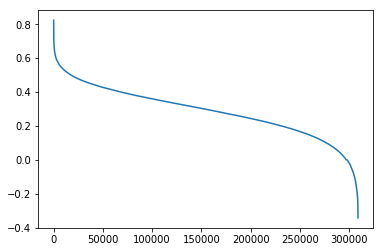

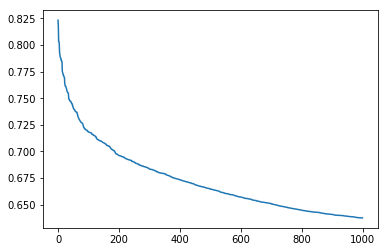

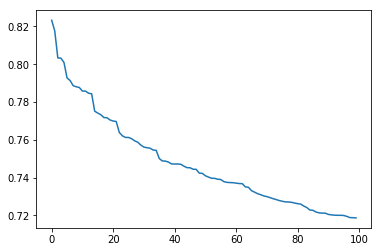

In [484]:
plt.plot(rankings[rankings_index])
plt.show()
plt.plot(rankings[rankings_index[:1000]])
plt.show()
plt.plot(rankings[rankings_index[:100]])
plt.show()

(array([4.0000e+00, 8.0000e+00, 1.2000e+01, 1.6000e+01, 2.6000e+01,
        4.2000e+01, 5.6000e+01, 5.3000e+01, 7.9000e+01, 1.2800e+02,
        1.3600e+02, 1.5500e+02, 1.7300e+02, 2.0800e+02, 2.4900e+02,
        2.8200e+02, 3.2700e+02, 3.7700e+02, 4.0900e+02, 4.6300e+02,
        5.0200e+02, 5.5000e+02, 6.1900e+02, 7.1100e+02, 7.6600e+02,
        8.6400e+02, 9.3200e+02, 1.1110e+03, 1.3360e+03, 2.2880e+03,
        1.5300e+03, 1.7980e+03, 2.0460e+03, 2.2180e+03, 2.5210e+03,
        2.8230e+03, 3.0770e+03, 3.3220e+03, 3.7520e+03, 4.0050e+03,
        4.4750e+03, 5.0620e+03, 5.4810e+03, 5.8500e+03, 6.2890e+03,
        6.7900e+03, 7.3610e+03, 7.7200e+03, 8.3670e+03, 8.8410e+03,
        9.1010e+03, 9.3150e+03, 9.7970e+03, 1.0158e+04, 1.0174e+04,
        1.0558e+04, 1.0395e+04, 1.0381e+04, 1.0348e+04, 1.0188e+04,
        9.8430e+03, 9.5700e+03, 8.8450e+03, 8.6520e+03, 7.9130e+03,
        7.4670e+03, 6.8970e+03, 6.1460e+03, 5.4660e+03, 5.0240e+03,
        4.2960e+03, 3.6690e+03, 3.2510e+03, 2.80

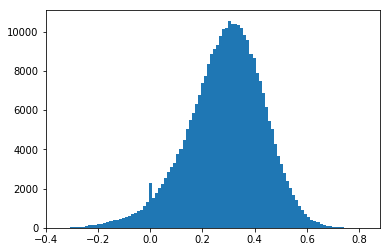

In [485]:
plt.hist(rankings[rankings_index], bins=100)

In [486]:
from sklearn.cluster import KMeans
from sklearn.metrics import pairwise_distances_argmin_min

In [487]:
TOP_HITS_KMEANS = 10
TOP_HITS_KMEANS2 = np.argmax(rankings[rankings_index] < .65)
if TOP_HITS_KMEANS2 < 20:
    TOP_HITS_KMEANS2 = np.argmax(rankings[rankings_index] < .55)
TOP_HITS_KMEANS2 = max(TOP_HITS_KMEANS2, 20)
print("{}-{}, {}-{}".format(0, TOP_HITS_KMEANS, TOP_HITS_KMEANS, TOP_HITS_KMEANS2))
ranked_titles = titles[rankings_index].tolist()
ranked_scores = scores[rankings_index].tolist()
top_ranked_em = n_weighted_embedding[rankings_index]
kmeans = KMeans(n_clusters=3, random_state=0).fit(top_ranked_em[:TOP_HITS_KMEANS])

0-10, 10-709


In [488]:
for i in range(min(20, TOP_HITS_KMEANS)):
    print(kmeans.labels_[i], "{:.4f}".format(rankings[rankings_index[i]]), titles[rankings_index[i]])

0 0.8233 TIL Cisgenders have their own language
1 0.8176 TIL the BBC website has a translated version of the news in Pidgin, a grammatically simplified form of a language, used for communication between people not sharing a common language.
1 0.8033 TIL India has no official language, with English being the most important language for national, political, and commercial communication
1 0.8032 TIL of Blissymbolics, an unspoken, written language that was invented as an easy to learn form of communication for use between people of all languages
1 0.8009 TIL Pidgin Language is the form of communication between people with no language in common
0 0.7928 TIL Sign language is not universal. There is about one sign language for each spoken language (and, for example, American English' Sign Language differs from British English' Sign Language).
1 0.7914 TIL Google can understand Birdperson's language
2 0.7886 TIL that Clicking through other languages on a Wikipedia article yields *tons* more in

In [489]:
closest, _ = pairwise_distances_argmin_min(kmeans.cluster_centers_, top_ranked_em[:TOP_HITS_KMEANS])

In [490]:
for c, i in enumerate(closest):
    print(c, ranked_titles[i])

0 TIL Cisgenders have their own language
1 TIL the BBC website has a translated version of the news in Pidgin, a grammatically simplified form of a language, used for communication between people not sharing a common language.
2 TIL that Clicking through other languages on a Wikipedia article yields *tons* more information, especially if you are multilingual, as some articles tend to be more comprehensive in other languages.


In [491]:
kmeans2 = KMeans(n_clusters=7, random_state=0).fit(top_ranked_em[TOP_HITS_KMEANS:TOP_HITS_KMEANS2])
closest2, _ = pairwise_distances_argmin_min(kmeans2.cluster_centers_, top_ranked_em[TOP_HITS_KMEANS:TOP_HITS_KMEANS2])
for c, i in enumerate(closest2):
    print(c, ranked_titles[i + TOP_HITS_KMEANS])

0 TIL Sign language is different in every language. You would think that being sign language and using your hands to communicate, the expressions would be universal.
1 TIL there is a language option on wikipedia called "Simple English" for people whose first language is not english, low level readers, and people who are having trouble understanding complex articles.
2 +9 2 TIL there is a web site where multiple people can write on a wall of text at the same time in real time
3 TIL That the German language was the second most spoken language in the United States but the use of the language was strongly suppressed during World War I.
4 Reddit TIL,Facebook is selling your data to advertisers as per the link.I have lots of personal information on Facebook and I assume that even you have put up personal information on your page.Does this make us vulnerable to threats of some form???
5 TIL google has a coding university where you can learn different programming and scripting languages for fr

# Doing more clusters and picking biggest ones

In [532]:
TOP_HITS_KMEANS = max(40,np.sum(scipy.stats.zscore(rankings[rankings_index]) > 3.5))
if TOP_HITS_KMEANS > 200:
    TOP_HITS_KMEANS = 200
print(TOP_HITS_KMEANS)
ranked_titles = titles[rankings_index].tolist()
top_ranked_em = n_weighted_embedding[rankings_index]
kmeans = KMeans(n_clusters=20, random_state=0).fit(top_ranked_em[:TOP_HITS_KMEANS])

40


In [533]:
import collections
counter = collections.Counter(kmeans.labels_)
most_common = counter.most_common(10)
most_common = [i[0] for i in most_common]
closest2, _ = pairwise_distances_argmin_min(kmeans.cluster_centers_[most_common], top_ranked_em[:TOP_HITS_KMEANS])
for c, i in enumerate(closest2):
    print(c, ranked_titles[i])

0 TIL of Blissymbolics, an unspoken, written language that was invented as an easy to learn form of communication for use between people of all languages
1 TIL: Sometimes, an English Wikipedia article is better written in another language I can understand
2 TIL there is a language option on wikipedia called "Simple English" for people whose first language is not english, low level readers, and people who are having trouble understanding complex articles.
3 TIL Cisgenders have their own language
4 TIL India has no official language, with English being the most important language for national, political, and commercial communication
5 TIL Sign language is not universal. There is about one sign language for each spoken language (and, for example, American English' Sign Language differs from British English' Sign Language).
6 TIL the BBC website has a translated version of the news in Pidgin, a grammatically simplified form of a language, used for communication between people not sharing a

# Instead of choosing point nearest to each centroid, choose the point with the highest similarity

In [494]:
def firstElementOfEachCluster(seq, num):
    clusters_included = set(most_common)
    res = {}
    for i, el in enumerate(seq):
        if el not in clusters_included:
            continue
        if el<10 and el not in res:
            res[el] = i
        if len(res) > num:
            return res
    
    return res

In [495]:
mostSimilarInEachCluster =  firstElementOfEachCluster(kmeans.labels_, 10)
ranked_rankings = rankings[rankings_index]
lst = []
for key in mostSimilarInEachCluster:
    lst.append((ranked_rankings[mostSimilarInEachCluster[key]], ranked_titles[mostSimilarInEachCluster[key]]))
lst = sorted(lst, key=lambda x: x[0], reverse = True)
for sim, fact in lst:
    print(sim, fact)

0.8032322 TIL of Blissymbolics, an unspoken, written language that was invented as an easy to learn form of communication for use between people of all languages
0.7927647 TIL Sign language is not universal. There is about one sign language for each spoken language (and, for example, American English' Sign Language differs from British English' Sign Language).
0.7913756 TIL Google can understand Birdperson's language
0.78863144 TIL that Clicking through other languages on a Wikipedia article yields *tons* more information, especially if you are multilingual, as some articles tend to be more comprehensive in other languages.
0.78768325 TIL there are over 200 different languages of sign language
0.75613725 TIL that if you type "define: [word here]" on google it actually gives you a list of definitions and functions as a dictionary rather than give you links to other websites.


In [496]:
# cluster number to top 10 based on similaitity
def top10OfEachCluster(seq, num):
    res = {}
    clusters_included = set(most_common)
    for i, el in enumerate(seq):
        if el not in clusters_included:
            continue
        if el not in res:
            res[el] = [i]
        elif len(res[el]) < num:
            res[el].append(i) 
    return res

In [497]:
kmeans.labels_

array([12, 19, 11,  3, 19,  1,  0,  8, 12,  4,  3,  4,  9,  1, 18,  3,  3,
       10, 17, 15, 12,  0, 14, 11, 16, 18,  1, 11,  3, 18,  2,  7, 18,  6,
        3,  5,  0, 13,  0,  2], dtype=int32)

## Take the 10 most similar and choose the top 4 based on score from each cluster

In [510]:
results = top10OfEachCluster(kmeans.labels_, 10)
results

{12: [0, 8, 20],
 19: [1, 4],
 11: [2, 23, 27],
 3: [3, 10, 15, 16, 28, 34],
 1: [5, 13, 26],
 0: [6, 21, 36, 38],
 8: [7],
 4: [9, 11],
 18: [14, 25, 29, 32],
 2: [30, 39]}

In [522]:
for key in results:
    results[key].sort(key=lambda x: ranked_scores[x], reverse = True)
    results[key] = results[key][:1]

In [523]:
for key in results:
    for idx in results[key]:
        print (key, "{:.4f}".format(ranked_rankings[idx]), ranked_scores[idx], ranked_titles[idx] )

12 0.8233 256.0 TIL Cisgenders have their own language
19 0.8009 13.0 TIL Pidgin Language is the form of communication between people with no language in common
11 0.8033 124.0 TIL India has no official language, with English being the most important language for national, political, and commercial communication
3 0.8032 838.0 TIL of Blissymbolics, an unspoken, written language that was invented as an easy to learn form of communication for use between people of all languages
1 0.7928 322.0 TIL Sign language is not universal. There is about one sign language for each spoken language (and, for example, American English' Sign Language differs from British English' Sign Language).
0 0.7488 49.0 TIL Wikipedia has a Simple English language for in-depth articles.
8 0.7886 1.0 TIL that Clicking through other languages on a Wikipedia article yields *tons* more information, especially if you are multilingual, as some articles tend to be more comprehensive in other languages.
4 0.7858 9.0 TIL th

In [524]:
results

{12: [0],
 19: [4],
 11: [2],
 3: [3],
 1: [5],
 0: [36],
 8: [7],
 4: [11],
 18: [14],
 2: [30]}

## ask user if they would like results by simialrity or score

In [534]:
def topResultsSorted(results, method = 'similarity'):
    if method == 'similarity':
        for key in results:
            results[key].sort(key=lambda x: ranked_rankings[x], reverse = True)
    elif method == 'score':
        for key in results:
            results[key].sort(key=lambda x: ranked_scores[x], reverse = True)
    return results       

In [535]:
results = [
            {
                "type": "submission",
                "title": self.index[d].title,
                "subreddit": self.index[d].subreddit,
                "permalink": self.index[d].permalink,
                "score": self.index[d].score,
            }
            for d in rel
        ]

NameError: name 'rel' is not defined

In [557]:
sorted_results = topResultsSorted(results, "score")
sorted_results

{12: [0],
 19: [4],
 11: [2],
 3: [3],
 1: [5],
 0: [36],
 8: [7],
 4: [11],
 18: [14],
 2: [30]}

In [558]:
sorted_x = sorted(sorted_results.items(), key=lambda x: x[1][0])
sorted_x

[(12, [0]),
 (11, [2]),
 (3, [3]),
 (19, [4]),
 (1, [5]),
 (8, [7]),
 (4, [11]),
 (18, [14]),
 (2, [30]),
 (0, [36])]

In [559]:
for cluster_id, l in sorted_x:
    print (cluster_id, "{:.4f}".format(ranked_rankings[l[0]]), 
           ranked_scores[l[0]],ranked_titles[l[0]])

12 0.8233 256.0 TIL Cisgenders have their own language
11 0.8033 124.0 TIL India has no official language, with English being the most important language for national, political, and commercial communication
3 0.8032 838.0 TIL of Blissymbolics, an unspoken, written language that was invented as an easy to learn form of communication for use between people of all languages
19 0.8009 13.0 TIL Pidgin Language is the form of communication between people with no language in common
1 0.7928 322.0 TIL Sign language is not universal. There is about one sign language for each spoken language (and, for example, American English' Sign Language differs from British English' Sign Language).
8 0.7886 1.0 TIL that Clicking through other languages on a Wikipedia article yields *tons* more information, especially if you are multilingual, as some articles tend to be more comprehensive in other languages.
4 0.7858 9.0 TIL that abbreviations in different languages use words that are also in that language


In [560]:
sorted_results = topResultsSorted(results)
sorted_x = sorted(sorted_results.items(), key=lambda x: x[1][0])
for cluster_id, l in sorted_x:
    print (cluster_id, "{:.4f}".format(ranked_rankings[l[0]]), 
           ranked_scores[l[0]],ranked_titles[l[0]])

12 0.8233 256.0 TIL Cisgenders have their own language
11 0.8033 124.0 TIL India has no official language, with English being the most important language for national, political, and commercial communication
3 0.8032 838.0 TIL of Blissymbolics, an unspoken, written language that was invented as an easy to learn form of communication for use between people of all languages
19 0.8009 13.0 TIL Pidgin Language is the form of communication between people with no language in common
1 0.7928 322.0 TIL Sign language is not universal. There is about one sign language for each spoken language (and, for example, American English' Sign Language differs from British English' Sign Language).
8 0.7886 1.0 TIL that Clicking through other languages on a Wikipedia article yields *tons* more information, especially if you are multilingual, as some articles tend to be more comprehensive in other languages.
4 0.7858 9.0 TIL that abbreviations in different languages use words that are also in that language
